# BeerQA – Open-domain Question Answering 

In this notebook we explore the BeerQA open-domain question answering dataset.
We analyse its structure and statistics, build sparse information retrieval
pipelines with PyTerrier, and study the semantic structure of questions and
contexts using word embeddings and clustering.


## Data load and exploration

### Imports

In this section we import the libraries used throughout the notebook
for data loading, visualisation and analysis.

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(7)

### Inspecting example documents

We load the different BeerQA splits (dataset, train, test) and print the
first document of each in a nicely formatted JSON view to understand the
structure of the files (fields, nesting, etc.).


The dataset is stored as a JSON file and consists of a list of documents.
Each document includes an `id`, the `source` dataset it comes from, the
`question`, and a `context` field containing one or more background
paragraphs (typically Wikipedia passages relevant to the question).


In [ ]:
def load_dataset(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def print_first_document(dataset, dataset_name):
    print(dataset_name)
    print(json.dumps(dataset['data'][3], indent=2)+"\n")

def print_num_documents(dataset, dataset_name):
    num_documents = len(dataset['data'])
    print("Number of documents", dataset_name + ":", num_documents)

dataset = load_dataset('beerqa_dev_v1.0.json')
train = load_dataset('beerqa_train_v1.0.json')
test = load_dataset('beerqa_test_questions_v1.0.json')

In [ ]:
print_num_documents(dataset, "DATASET")
print_num_documents(train, "TRAIN")
print_num_documents(test, "TEST")

Number of documents DATASET: 14121
Number of documents TRAIN: 134043
Number of documents TEST: 14932


We can see that the test set contains only questions, without annotated
contexts or answers, and is meant for blind evaluation.


In [ ]:
print_first_document(dataset, "DATASET")
print_first_document(train, "TRAIN")
print_first_document(test, "TEST")

DATASET
{
  "id": "5a7e0582b269da476adcb07d7c81770aa7e40e36",
  "src": "squad",
  "answers": [
    "general appearance"
  ],
  "question": "What does the FBI employ the term race to summarize?",
  "context": [
    [
      "Race (human categorization)",
      "In an attempt to provide general descriptions that may facilitate the job of law enforcement officers seeking to apprehend suspects, the United States FBI employs the term \"race\" to summarize the general appearance (skin color, hair texture, eye shape, and other such easily noticed characteristics) of individuals whom they are attempting to apprehend. From the perspective of law enforcement officers, it is generally more important to arrive at a description that will readily suggest the general appearance of an individual than to make a scientifically valid categorization by DNA or other such means. Thus, in addition to assigning a wanted individual to a racial category, such a description will include: height, weight, eye color

### Visualisation of basic statistics

In this section we plot basic statistics about the BeerQA splits, such as
the number of contexts per question and the average lengths of questions
and contexts.


The following plot shows how many documents have 1, 2, 3, ... contexts in
each split. This helps us understand how “multi-hop” the questions are.


In [ ]:
def count_documents_by_context(dataset):
    context_counts = {}
    for document in dataset['data']:
        num_contexts = len(document['context'])
        if num_contexts not in context_counts:
            context_counts[num_contexts] = 1
        else:
            context_counts[num_contexts] += 1
    return context_counts

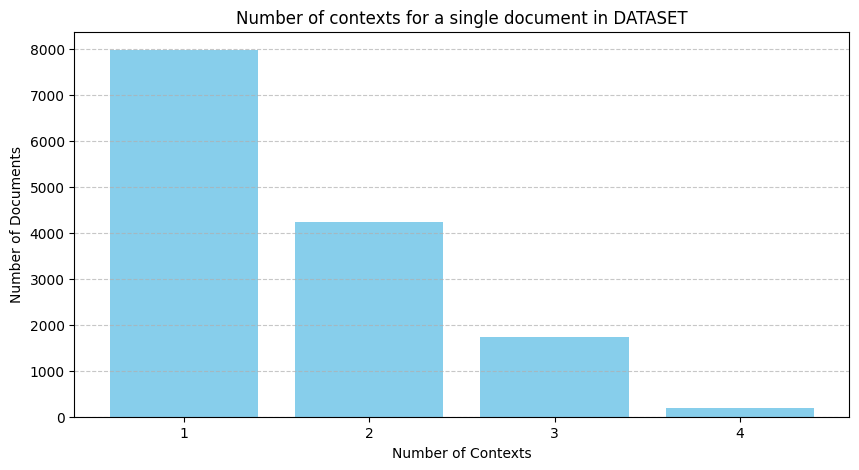

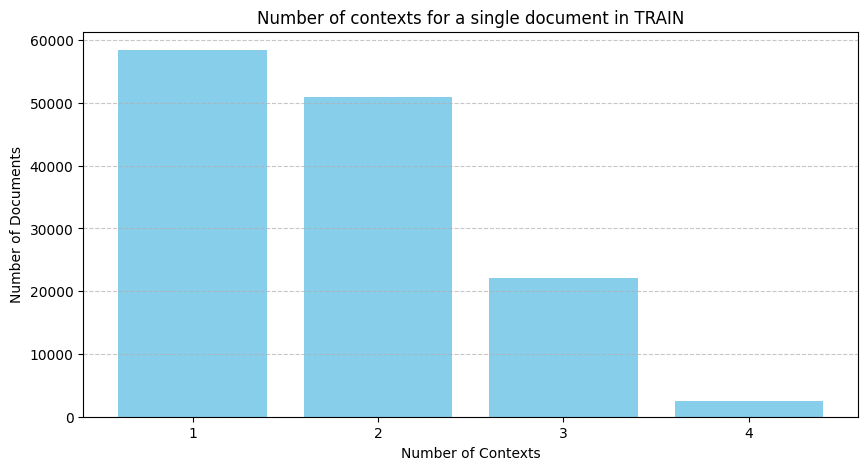

In [ ]:
total_data = [dataset, train]
sets = ["DATASET","TRAIN"]

for i,data in enumerate(total_data):

    documents_by_context = count_documents_by_context(data)

    num_contexts = list(documents_by_context.keys())
    counts = list(documents_by_context.values())

    plt.figure(figsize=(10, 5))
    plt.bar(num_contexts, counts, color='skyblue')
    plt.xlabel('Number of Contexts')
    plt.ylabel('Number of Documents')
    plt.title('Number of contexts for a single document in '+sets[i])
    plt.xticks(num_contexts)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


We compute the average lengths of questions and contexts for the main dataset,
the training set and the test set. These results provide a quick overview of
typical question and context sizes.


In [ ]:
def compute_average_question_length(dataset):
    total_question_length = 0
    num_documents = len(dataset['data'])

    for document in dataset['data']:
        question_length = len(document['question'].split())
        total_question_length += question_length

    average_question_length = total_question_length / num_documents
    return average_question_length

def compute_average_context_length(dataset):
    total_context_length = 0
    num_documents = len(dataset['data'])

    for document in dataset['data']:
        for context_array in document['context']:
            for sentence in context_array:
                context_length = len(sentence.split())
                total_context_length += context_length

    average_context_length = total_context_length / num_documents
    return average_context_length

In [ ]:
total_data = [dataset, train, test]
sets = ["DATASET", "TRAIN", "TEST"]

for i in range(len(total_data)):
    print(sets[i])
    # Compute average context and question length (in tokens, without removing punctuation)
    if(i<2):
        average_context_length = compute_average_context_length(total_data[i])
        print("Average Context Length: %.2f" % average_context_length)

    average_question_length = compute_average_question_length(total_data[i])
    print("Average Question Length: %.2f" % average_question_length)
    print()

DATASET
Average Context Length: 147.48
Average Question Length: 12.54

TRAIN
Average Context Length: 152.88
Average Question Length: 14.34

TEST
Average Question Length: 12.64



We also perform a more detailed analysis of answer and context statistics.
To do this, we convert the `train` split (the largest one) into a Pandas
dataframe. The initial dataframe is mostly for inspection and is refined
later when needed.


In [ ]:
df = pd.DataFrame(train['data'])
df.head(5)

,id,src,answers,question,context
0,8af07575b8444ae748634478f96b00d4e7dbd170,squad,[1793],When did Wordsworth initially attack Burke?,"[[Edmund Burke, In the 19th century, Burke was..."
1,7e07be1a905b70f143b2c8aff00caf16e2b32b31,squad,[Investiture Controversy],The clash between Henry IV and the pope was pa...,"[[Middle Ages, During the early High Middle Ag..."
2,c9dfc01655bc5abc59a1ee2583c8b3f7fba6c2e2,squad,[the Thermidorian Reaction],What historical event brought about the fall o...,"[[Napoleon, Some contemporaries alleged that B..."
3,cf10ffbb5023cd0bc4637655458512b2186dc886,squad,[Morales],Who came up with a policy for indigenous auton...,"[[Indigenous peoples of the Americas, Morales ..."
4,0a185aca81f9e36bfb2486f690885011a6aefb2e,hotpotqa,[Darren Lynn Bousman],"Greg Hoffman was working on ""Saw III,"" a 2006 ...","[[Saw III, Saw III is a 2006 horror film direc..."


We count how many distinct answers appear in the training set. We notice that
a large portion of them are simply “yes” or “no”.


In [ ]:
for row in range(len(df)):
  df.iloc[row]['answers'] = (df.iloc[row]['answers'])[0]

In [ ]:
answers_counts = df['answers'].value_counts()
print("Count of the different answers:")
print(answers_counts)

Count of the different answers:
answers
no                   2477
yes                  2457
American              569
United States         256
two                   233
                     ... 
September 8, 2013       1
John Harrison           1
John Snow               1
Jornado                 1
March 11, 2010          1
Name: count, Length: 85200, dtype: int64


We observe that each context is composed of one or more *(title, paragraph)* pairs.
We therefore check for overlaps between titles and paragraphs. This means that:

* the same topic (title) can be used as context for multiple questions  
* the same paragraph may appear as context for more than one question  

In the following cells we show that the first hypothesis is true, and later we
confirm that paragraph-level reuse also occurs.


In [ ]:
paragraph_counts = {}
for index, row in df.iterrows():
    for context_array in row['context']:
        paragraph_title = context_array[0]
        if paragraph_title in paragraph_counts:
            paragraph_counts[paragraph_title] += 1
        else:
            paragraph_counts[paragraph_title] = 1

sorted_paragraph_counts = dict(sorted(paragraph_counts.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# Truncating the output, otherwise it would be too long
print("Top 10 most recurrent titles in the dataset:")
for tcount in list(sorted_paragraph_counts.items())[:10]:
  print(tcount[0], ":", tcount[1])

Top 10 most recurrent titles in the dataset:
American Idol : 694
Frédéric Chopin : 656
New York City : 655
Queen Victoria : 632
Beyoncé : 584
New Haven, Connecticut : 555
2008 Sichuan earthquake : 448
Middle Ages : 442
Napoleon : 407
Muammar Gaddafi : 394


## Indexing and search

### Creation of the dataset for indexing
The dataset in its dictionary form is not suitable for indexing. So, some pre-processing is needed.



Every document has a `context` field, which is composed of one or more
*(title, paragraph)* pairs. Each paragraph is therefore associated with a
title. From each document we extract all such pairs and build a flat list
of (title, paragraph) entries. The indexing is then performed over this
list of paragraphs.


In [ ]:
# Collect training documents in a list for easier processing
documentsTrain = []
# Iterate over each data item and append it to the list
for item in train['data']:
    documentsTrain.append(item)

In [ ]:
# Create a dataframe to store paragraph entries: (docno, title, text)
docs_df = pd.DataFrame(columns=["docno", "title", "text"])

In [ ]:
pid = 0 # Tmp indexes

# Iteration over the selected documents to generate (title,paragraph) pairs
for doc in documentsTrain:
  for con in doc['context']:
    title = con[0]
    text = con[1]
    str_pid = "P"+str(pid)
    tmp_df = pd.DataFrame([[str_pid,title,text]], columns=docs_df.columns)
    docs_df = pd.concat([tmp_df, docs_df], ignore_index=True)
    pid = pid + 1

In [ ]:
# Turn everything into strings
docs_df = docs_df.convert_dtypes()
docs_df.dtypes

docno    string[python]
title    string[python]
text     string[python]
dtype: object

In [ ]:
# Display the obtained dataset
pd.set_option('display.max_colwidth', 150)
docs_df.head()

,docno,title,text
0,P236809,Hipparchus,"Hipparchus of Nicaea ( ; , ""Hipparkhos""; ) was a Greek astronomer, geographer, and mathematician. He is considered the founder of trigonometry bu..."
1,P236808,NGC 884,NGC 884 (also known as χ Persei) is an open cluster located 7600 light years away in the constellation of Perseus. It is the easternmost of the Do...
2,P236807,Shoegazing,"Most shoegazing artists drew from the glide guitar template set by My Bloody Valentine on their early EPs and album ""Isn't Anything"" from the late..."
3,P236806,Shoegazing,"Shoegazing (or shoegaze, initially referred to as ""dream pop"") is a subgenre of indie and alternative rock that emerged in the United Kingdom in t..."
4,P236805,Lovesliescrushing,"Guest musicians have joined the group for live performances, including Michael Anderson (Turn Pale, Drekka), Ana Breton (Dead Leaf Echo, Mahogany)..."


As stated before, we check whether there are duplicated paragraphs in the
index. Our hypothesis is that the same paragraph can be used as context
for more than one question. The analysis confirms that this is indeed the
case.


In [ ]:
# Remove exact duplicates
clean_docs_df = docs_df.drop_duplicates(subset=['title','text'])
print(f'Found {len(docs_df)-len(clean_docs_df)} exact duplicates over {len(docs_df)} (title-paragraph) couples.')

Found 117495 exact duplicates over 236810 (title-paragraph) couples.


In [ ]:
# Save the obtained dataframe
clean_docs_df.to_csv('title_text_clean_df.csv')

In conclusion, we observe that even after cleaning there is still a consistent
overlap of titles. This confirms that the dataset contains multiple paragraphs
about the same topic, which can be useful for multi-hop reasoning.


In [ ]:
print(clean_docs_df.groupby(['title'])['title'].count().sort_values(ascending=False))

title
New York City         147
American Idol         127
Napoleon              102
Portugal              100
Hellenistic period     96
                     ... 
Gordon Lightfoot        1
Gordon L. Kane          1
Gordon Kuhrt            1
Gordon Kaufmann         1
Ṣād (surah)             1
Name: title, Length: 89747, dtype: int64


The most frequent title is "New York City". We display a sample of 5 paragraphs that have the city as title. We can observe that they are about different topics related to New York.

In [ ]:
clean_docs_df[clean_docs_df['title']=='New York City'].head(5)

,docno,title,text
294,P236515,New York City,"The Fire Department of New York (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive haza..."
1137,P235672,New York City,"New York City is situated in the northeastern United States, in southeastern New York State, approximately halfway between Washington, D.C. and Bo..."
1414,P235395,New York City,HHC's facilities annually provide millions of New Yorkers services interpreted in more than 190 languages. The most well-known hospital in the HHC...
1688,P235121,New York City,"In 1904, the steamship ""General Slocum"" caught fire in the East River, killing 1,021 people on board. In 1911, the Triangle Shirtwaist Factory fir..."
2041,P234768,New York City,"The city's population in 2010 was 44% white (33.3% non-Hispanic white), 25.5% Black or African American (23% non-Hispanic black), 0.7% Native Amer..."


### Indexing with PyTerrier

#### Install and load PyTerrier


In [ ]:
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup

In [ ]:
import pyterrier as pt

if not pt.started():
  pt.init()

terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



#### Indexing the paragraphs

We perform the indexing operation over the cleaned list of paragraphs. The
`title` field is kept as a label, so that we can later interpret search
results and evaluate how meaningful the retrieved documents are.


In [ ]:
# Load the cleaned dataframe
clean_docs_df = pd.read_csv("title_text_clean_df.csv", index_col=0)
clean_docs_df = clean_docs_df.convert_dtypes()

In [ ]:
# Creation of the indexer
indexer = pt.DFIndexer("./index_rnddocs", overwrite=True, verbose=True)
index_ref = indexer.index(clean_docs_df["text"],clean_docs_df["docno"]) # Don't change names
index_ref.toString()

  0%|          | 0/119315 [00:00<?, ?documents/s]

18:31:05.598 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (P220052) - further warnings are suppressed
18:33:34.074 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 1 empty documents


'./index_rnddocs/data.properties'

In [ ]:
# Load the index
index = pt.IndexFactory.of(index_ref)

In [ ]:
# Print some stats
print(">>> INDEX STATISTICS <<<")
print(index.getCollectionStatistics().toString())

>>> INDEX STATISTICS <<<
Number of documents: 119315
Number of terms: 154451
Number of postings: 4500612
Number of fields: 0
Number of tokens: 5484295
Field names: []
Positions:   false



In [ ]:
# Print a small piece of the lexicon
print(">>> SOME LEXICON <<<")
lexicon = index.getLexicon()
for i in range(5):
    print(lexicon[i].getKey(),": ", lexicon[i].getValue().toString())

>>> SOME LEXICON <<<
hipparkho :  term0 Nt=1 TF=1 maxTF=2147483647 @{0 3565239 0}
mathematician :  term1 Nt=259 TF=293 maxTF=2147483647 @{0 4619231 7}
equinox :  term2 Nt=11 TF=15 maxTF=2147483647 @{0 2740064 6}
trigonometri :  term3 Nt=10 TF=10 maxTF=2147483647 @{0 7265575 2}
greek :  term4 Nt=1134 TF=1655 maxTF=2147483647 @{0 3362614 2}


#### Querying the index
We query the obtained index on some topics related to the most frequent titles.

To query the index, we use 3 pipelines, in which we mix some of the most important wighting scores:
* Top 100 results with BM25.
* Top 100 results with TF-IDF rescored with BM25.
* Top 100 results with PL2 rescored with BM25.

In [ ]:
# Creation of the pipelines
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

# Mixed pipelines
bm25_top100 = bm25 % 100
tf_idf_bm25_top100 = (tf_idf % 100) >> bm25
pl2_bm25_top100 = (pl2 % 100) >> bm25

Since the length of the paragraphs is not huge, we perform the search directly on them, without using passages.
We perform a set of 3 queries related to the most frequent titles.


In [ ]:
queries = pd.DataFrame([["Q1", "Empire State Building"], ["Q2", "Simon Cowell"], ["Q3", "Saint Helena"]], columns=["qid", "query"])
bm25_top100_results = bm25_top100(queries)
tf_idf_bm25_top100_results = tf_idf_bm25_top100(queries)
pl2_bm25_top100_results = pl2_bm25_top100(queries)

#### Evaluation and visualization of the results
In our dataset, we don't have a set of queries paired with a set of relevance for our documents. So, we opted for a "visual" exploration and evaluation of the results.

We could create the relevance scores by assigning higher scores to paragraphs that contain the query or part of it, but it would be too artificial as it would not represent the real ground truth. For the same reason, it would be hard to create a model that learns to rank.

We visualize the top results for each query and for each pipeline.


In [ ]:
# Extract the top 5 results for every pipeline and query
bm25_top5 = bm25_top100_results.loc[(bm25_top100_results['rank'] >= 0) & (bm25_top100_results['rank'] <= 4)]
tf_idf_bm25_top5 = tf_idf_bm25_top100_results.loc[(tf_idf_bm25_top100_results['rank'] >= 0) & (tf_idf_bm25_top100_results['rank'] <= 4)]
pl2_bm25_top5 = pl2_bm25_top100_results.loc[(pl2_bm25_top100_results['rank'] >= 0) & (pl2_bm25_top100_results['rank'] <= 4)]

We check if the pipelines brought to a difference in the results. We see that the top 5 (at least in the ranking) is equal in all the pipelines.

In [ ]:
# Build a dataframe with all the values
compare_df = pd.DataFrame()
compare_df['query'] = bm25_top5['query'].values

# Adding bm25 values
compare_df['bm25_rank'] = bm25_top5['rank'].values
compare_df['bm25_docno'] = bm25_top5['docno'].values

# Adding tf_idf_bm25 values
compare_df['tf_idf_bm25_rank'] = tf_idf_bm25_top5['rank'].values
compare_df['tf_idf_bm25_docno'] = tf_idf_bm25_top5['docno'].values

# Adding pl2_bm25 values
compare_df['pl2_bm25_rank'] = pl2_bm25_top5['rank'].values
compare_df['pl2_bm25_docno'] = pl2_bm25_top5['docno'].values

In [ ]:
compare_df

,query,bm25_rank,bm25_docno,tf_idf_bm25_rank,tf_idf_bm25_docno,pl2_bm25_rank,pl2_bm25_docno
0,Empire State Building,0,P186217,0,P186217,0,P186217
1,Empire State Building,1,P69271,1,P69271,1,P69271
2,Empire State Building,2,P229516,2,P229516,2,P229516
3,Empire State Building,3,P201512,3,P201512,3,P201512
4,Empire State Building,4,P162685,4,P162685,4,P162685
5,Simon Cowell,0,P128332,0,P128332,0,P128332
6,Simon Cowell,1,P223701,1,P223701,1,P223701
7,Simon Cowell,2,P46020,2,P46020,2,P46020
8,Simon Cowell,3,P234060,3,P234060,3,P234060
9,Simon Cowell,4,P186930,4,P186930,4,P186930


Now we display the top 5 articles for every query. We perform the operation only on `bm_25` since the results of the top were equal.

In [ ]:
# Merge back results with the original paragraphs
bm25_top5 = pd.merge(bm25_top5, clean_docs_df, on="docno", how="inner")
tf_idf_bm25_top5 = pd.merge(tf_idf_bm25_top5, clean_docs_df, on="docno", how="inner")
pl2_bm25_top5 = pd.merge(pl2_bm25_top5, clean_docs_df, on="docno", how="inner")

In [ ]:
bm25_top5

,qid,docid,docno,rank,score,query,title,text
0,Q1,40720,P186217,0,22.562185,Empire State Building,Empire State Building,"The Empire State Building is a 102-story Art Deco skyscraper in Midtown Manhattan in New York City. It was designed by Shreve, Lamb & Harmon and b..."
1,Q1,96922,P69271,1,18.697005,Empire State Building,Hoboken City Hall,"Hoboken City Hall, is located in Hoboken, Hudson County, New Jersey, United States. The building was designed by Francis G. Himpler and was built ..."
2,Q1,7077,P229516,2,17.927491,Empire State Building,Chrysler Building,"The Chrysler Building is an Art Deco–style skyscraper located in the Turtle Bay neighborhood on the East Side of Manhattan, New York City, at the ..."
3,Q1,30167,P201512,3,17.555285,Empire State Building,Accrington,Accrington is a former centre of the cotton and textile machinery industries. The town is famed for manufacturing the hardest and densest building...
4,Q1,55155,P162685,4,17.422999,Empire State Building,Accrington brick,"Accrington bricks, or Noris are a type of iron-hard engineering brick, produced in Altham near Accrington, Lancashire, England from 1887 to 2008 a..."
5,Q2,72787,P128332,0,26.810037,Simon Cowell,Fanfare Records,"Fanfare Records was a British record label that was founded by Iain Burton (dancer in The Young Generation, manager of Arlene Phillips and co-foun..."
6,Q2,12354,P223701,1,25.754741,Simon Cowell,American Idol,"A special tribute to Simon Cowell was presented in the finale for his final season with the show. Many figures from the show's past, including Pau..."
7,Q2,105069,P46020,2,24.575949,Simon Cowell,X Factor (Belgian TV series),"X Factor was the Flemish version of the British show ""The X Factor"" that was created by Simon Cowell. The new ""X Factor"" series was a postcursor t..."
8,Q2,2703,P234060,3,21.477339,Simon Cowell,Simon Cowell,"Simon Phillip Cowell ( ; born 7 October 1959) is an English television personality, entrepreneur, entertainment manager, and record executive. He ..."
9,Q2,40277,P186930,4,21.393603,Simon Cowell,Factor X (Portuguese TV series),"Factor X was the Portuguese version of the television music competition ""The X Factor"", originally created by Simon Cowell. The first episode prem..."


### Bubbleplot of results

Creation of a bubble plot where the most frequent labels in the results correpsond to the biggest bubbles. We use them to visually compare the results of the different pipelines.

#### BubbleChart Class
The BubbleChart class is taken from the official website of Matplotlib and it has been modified to suit our results (credits: [matplotlib library](https://matplotlib.org/stable/gallery/misc/packed_bubbles.html#sphx-glr-gallery-misc-packed-bubbles-py)).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import minmax_scale

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        # ADDED: sort colors in decreasing order
        alpha = np.linspace(10, 100, num=len(area)-1, endpoint=False)
        alpha = -np.sort(-alpha)
        colors = [mcolors.CSS4_COLORS['cornflowerblue']]
        for i in range(len(alpha)):
          colors.append(colors[0]+str(int(alpha[i])))

        # ADDED: sort fontsizes
        self.fonts = minmax_scale(area, (6,12))

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2
        self.colors = colors

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=self.colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center', fontsize=self.fonts[i])

#### Aggregation of the results
For each pipeline and query, we aggregate the results to see which is the most impacting title in the results.

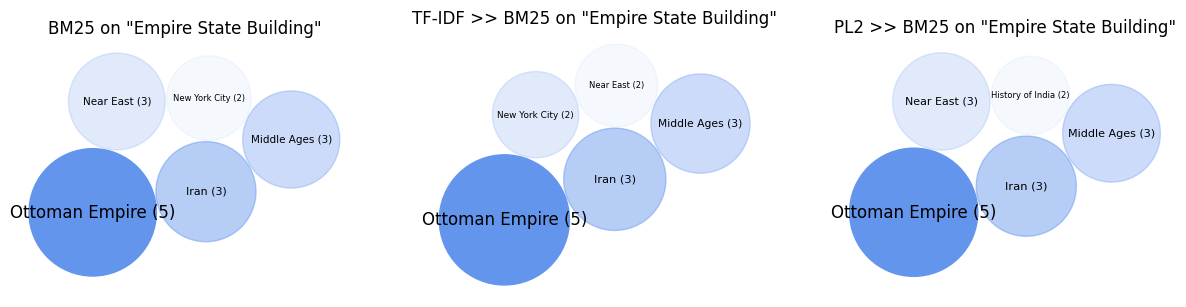

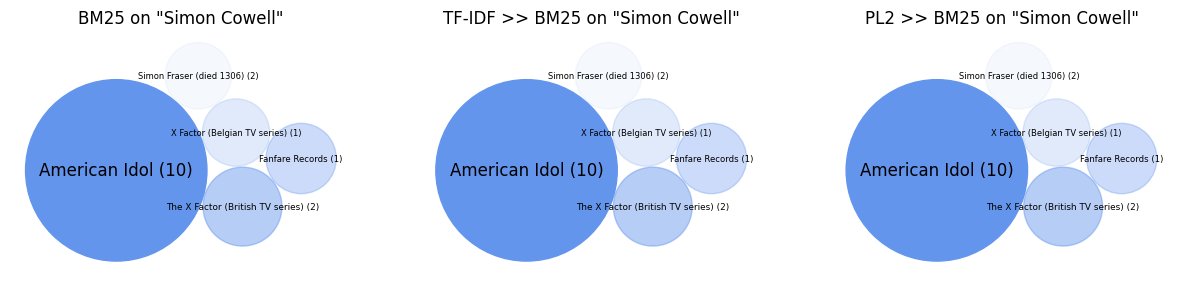

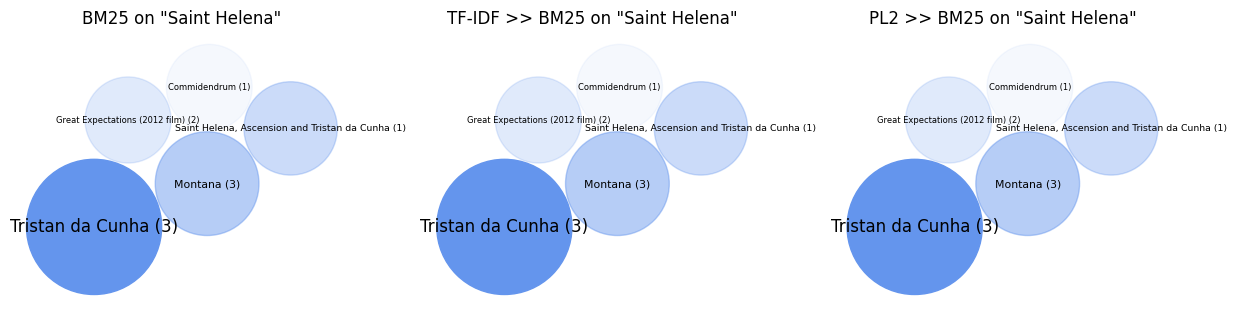

In [ ]:
results = [bm25_top100_results, tf_idf_bm25_top100_results, pl2_bm25_top100_results]
titles = ["BM25","TF-IDF >> BM25","PL2 >> BM25"]

# For each query
for q in queries['qid']:

  fig, axs = plt.subplots(1,3,figsize=(15, 15),subplot_kw=dict(aspect="equal"))

  # For each result
  for idx in range(len(results)):

    # Extraction, merge and filtering for query
    tmp = results[idx]
    tmp = pd.merge(tmp, clean_docs_df, on="docno", how="inner")
    tmp = tmp[tmp['qid'] == q]

    # Aggregation of results
    tmp = tmp.groupby("title").agg({
        "qid": "count",  # Count the rows
        "score": "sum"   # Sum the "score" column
    }).reset_index()

    # Sort in decreasing order
    tmp = tmp.sort_values('score', ascending=False)

    # Top 5 labels
    top_labels = tmp['title'].to_numpy()[:5] + " (" + tmp['qid'].to_numpy().astype(str)[:5] +")"
    top_scores = tmp['score'].to_numpy()[:5]

    # Plot
    bubble_chart = BubbleChart(area = top_scores, bubble_spacing=0.1)
    bubble_chart.collapse()
    bubble_chart.plot(axs[idx], top_labels)
    axs[idx].axis("off")
    axs[idx].relim()
    axs[idx].autoscale_view()
    axs[idx].set_title(titles[idx] + " on \"" + queries[queries['qid'] == q].iloc[0]['query'] + "\"")

  plt.show()

## Word embeddings

Word embeddings allow us to transform words into a high-dimensional space where semantically similar words are positioned closer together. So, we can capture the context and relationships between words.

Visualizing word embeddings can provide insights into these semantic relationships that we can exploit in the following steps, when we will train machine learning models. Then, we will visualize a sample of these embeddings, to eventually observe clusters of similar words.


### Preparing for Word2Vec: tokenization
We take into account answers, questions and contexts.


In [ ]:
import re
from pandas.core.common import flatten

# Assuming documentsTrain is a list of dictionaries, where each dictionary
# contains the following "interesting" keys

string_keys = ["answers", "question", "context"]
sentences = []

# Iterate over each document in documentsTrain
for document in documentsTrain:

    for key in string_keys:

        if key != "question":

            flattened_values = flatten(document[key])

            for value in flattened_values:

                # Ensure value is a string
                if isinstance(value, str):

                    # # Split at any punctuation between [?!.]
                    value_sentences = re.split(r'[?!.]\s?', value)
                    sentences.extend(value_sentences)

        else:

            # Split at any punctuation between [?!.]
            value_sentences = re.split(r'[?!.]\s?', document[key])
            sentences.extend(value_sentences)

# Now 'sentences' contains all the split sentences from the specified keys across all documents
print("Total sentences:", len(sentences))

Total sentences: 1903149


We print a sample of the splitted sentences.

In [ ]:
# Print a sample of the split sentences
num_samples = 10  # Number of sentences to print as a sample
print(f"Sample of {num_samples} sentences:")
for i in range(min(num_samples, len(sentences))):
    print(f"Sentence {i + 1}: {sentences[i]}")

Sample of 10 sentences:
Sentence 1: 1793
Sentence 2: When did Wordsworth initially attack Burke
Sentence 3: 
Sentence 4: Edmund Burke
Sentence 5: In the 19th century, Burke was praised by both liberals and conservatives
Sentence 6: Burke's friend Philip Francis wrote that Burke "was a man who truly & prophetically foresaw all the consequences which would rise from the adoption of the French principles", but because Burke wrote with so much passion, people were doubtful of his arguments
Sentence 7: William Windham spoke from the same bench in the House of Commons as Burke had when he had separated from Fox and an observer said Windham spoke "like the ghost of Burke" when he made a speech against peace with France in 1801
Sentence 8: William Hazlitt, a political opponent of Burke, regarded him as amongst his three favourite writers (the others being Junius and Rousseau) and made it "a test of the sense and candour of any one belonging to the opposite party, whether he allowed Burke to be

Some empty sentences are left, so we remove them whilw we tokenize each sentence into single words.

In [ ]:
# Tokenize sentences and filter out single-word sentences
tokenized_sentences = [
    re.sub(r'\W', ' ', sentence).lower().split()
    for sentence in sentences
    if len(re.sub(r'\W', ' ', sentence).split()) > 1
]

#Print a sample of tokenized sentences
num_samples = 10  # Number of sentences to print as a sample
print(f"Sample of {num_samples} tokenized sentences:")
for sentence in tokenized_sentences[:num_samples]:
  print(sentence)

Sample of 10 tokenized sentences:
['when', 'did', 'wordsworth', 'initially', 'attack', 'burke']
['edmund', 'burke']
['in', 'the', '19th', 'century', 'burke', 'was', 'praised', 'by', 'both', 'liberals', 'and', 'conservatives']
['burke', 's', 'friend', 'philip', 'francis', 'wrote', 'that', 'burke', 'was', 'a', 'man', 'who', 'truly', 'prophetically', 'foresaw', 'all', 'the', 'consequences', 'which', 'would', 'rise', 'from', 'the', 'adoption', 'of', 'the', 'french', 'principles', 'but', 'because', 'burke', 'wrote', 'with', 'so', 'much', 'passion', 'people', 'were', 'doubtful', 'of', 'his', 'arguments']
['william', 'windham', 'spoke', 'from', 'the', 'same', 'bench', 'in', 'the', 'house', 'of', 'commons', 'as', 'burke', 'had', 'when', 'he', 'had', 'separated', 'from', 'fox', 'and', 'an', 'observer', 'said', 'windham', 'spoke', 'like', 'the', 'ghost', 'of', 'burke', 'when', 'he', 'made', 'a', 'speech', 'against', 'peace', 'with', 'france', 'in', '1801']
['william', 'hazlitt', 'a', 'political'

### Creation of Word2Vec


In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

### Visualising the most similar embedding vectors to a random one using T-SNE

We select a term at random, identify the 10 terms most closely related to it, and then employ t-SNE to visualize these terms in a compressed space alongside additional terms.

In [ ]:
sentence = np.random.choice(len(tokenized_sentences))
term = np.random.choice(len(tokenized_sentences[sentence]))
term = tokenized_sentences[sentence][term]
print(f"Random term: {term}")

Random term: eurovision


In [ ]:
# Top 10 similar terms
top_similar = model.wv.most_similar(term)
top_similar

[('contest', 0.6847594976425171),
 ('sayrna', 0.6718044281005859),
 ('undone', 0.6412906646728516),
 ('moldovan', 0.6246471405029297),
 ('mnet', 0.6224752068519592),
 ('headlined', 0.6201103925704956),
 ('heralding', 0.6185898184776306),
 ('assago', 0.6167372465133667),
 ('finalist', 0.614215075969696),
 ('laulupidu', 0.6037076115608215)]

We now visualise some of the word vectors in a 3-dimensional space using t-SNE.
We sample a random subset of 200 terms and explicitly add the most similar
terms to a chosen target word.


In [ ]:
# Random sample
sample = np.random.choice(list(model.wv.key_to_index), size = 200, replace = False)

# List of most similar words
top_similar_list = [e[0] for e in top_similar]

# Merge everything and remove duplicates (while keeping the order)
sample = [term] + top_similar_list + list(sample)
sample = list(dict.fromkeys(sample))
print(f"Obtained size {len(sample)} sample: {sample}")

Obtained size 211 sample: ['eurovision', 'contest', 'sayrna', 'undone', 'moldovan', 'mnet', 'headlined', 'heralding', 'assago', 'finalist', 'laulupidu', 'piñata', 'jodocus', 'tricycle', 'vachon', 'šťastný', 'stoicism', 'photons', 'chiefly', 'truck', 'kasımpaşa', 'exploratorium', 'sensitivities', 'shyamalan', 'disconnected', 'solidified', 'preloaded', 'hort', 'regen', 'lobos', 'watertown', 'mikalaevich', 'meantime', 'victims', 'k35dg', 'footnotes', 'colsterworth', 'furpaw', 'potomac', 'demarcation', 'seropian', 'pairings', 'jaworski', 'cheat', 'jtbc', 'mondelez', 'ghost', 'clink', 'belfort', 'tubenoses', 'electrodynamics', 'citycenter', 'phage', 'nerdist', 'callimachus', 'unanimous', 'lanka', 'sagas', 'toadies', 'fordham', 'cus', 'boltzmann', 'whitworth', 'grasping', 'ym', 'transpro', 'shove', 'ridership', 'mcdermid', 'canard', 'undisturbed', 'nynne', 'prendergast', 'nussbaum', 'doyen', 'jesuits', 'qurbanova', 'kushan', 'kudrow', 'geoffrey', 'darke', 'glycylcyclines', 'descendent', 'kov

Then, we apply T-SNE in 3 dimensions and we plot the result.

In [ ]:
from sklearn.manifold import TSNE

word_vectors = model.wv[sample]
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

In [ ]:
# Turn the embedding into a dataframe and add plot info
plot_df = pd.DataFrame(tsne_embedding, columns = ["x","y","z"])
plot_df['word'] = sample
plot_df['label'] = [term] + ["Similar words" for i in range(10)] + ["Other words" for i in range(200)]
plot_df.head(15)

,x,y,z,word,label
0,21.943861,-5.828444,-117.342949,eurovision,eurovision
1,-124.888290,105.466103,-20.311287,contest,Similar words
2,10.987280,81.247688,-101.689713,sayrna,Similar words
3,20.438267,53.176842,-133.814636,undone,Similar words
4,109.340599,72.864799,-59.132351,moldovan,Similar words
5,1.096393,25.003969,-142.609390,mnet,Similar words
6,-13.326928,2.104539,-125.086739,headlined,Similar words
7,-42.997707,33.844444,-142.200089,heralding,Similar words
8,-22.157499,82.259399,-130.623138,assago,Similar words
9,10.446282,-8.036604,-152.017059,finalist,Similar words


In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px

In the plot we can see that the most similar words are close to the target
one, although some outliers appear farther away. This can be due to the
information loss introduced by the t-SNE dimensionality reduction.


In [ ]:
fig = px.scatter_3d(plot_df, x='x',y='y',z='z',text='word',color='label')
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=8)
fig.show()

## Clustering



We apply clustering to group similar paragraphs and uncover potential
underlying patterns. As in the indexing part, we use titles as labels to
qualitatively validate the coherence and relevance of the clusters.


### Data load and transformation

In [ ]:
# Load the cleaned dataframe
clean_docs_df = pd.read_csv("title_text_clean_df.csv", index_col=0)
clean_docs_df = clean_docs_df.convert_dtypes()

In [ ]:
# Put the titles and the contexts in two different lists
labels = clean_docs_df['title'].to_list()
ctx = clean_docs_df['text'].to_list()

### Vectorization
The `TfidfVectorizer` is designed to transform a list of contexts into vectors
by computing the term frequency and multiplying it by the inverse document
frequency of each term across the corpus. The result is a weighted value for
each term in the vector representation.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

We obtain the vocabulary of the dataset and the TF–IDF vector representation
for each document.


In [ ]:
vector_documents = vectorizer.fit_transform(ctx)

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 48932


In [ ]:
# Average number of non-zero terms per document (document vocabulary size)
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]

print(f"Average document vocabulary size: {nonzero_count/doc_count}")

Average document vocabulary size: 35.73356241880736


Show the words of the first document and their vector form.

In [ ]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('precession', 0.36153082427438443),
 ('hipparchus', 0.3570373935778353),
 ('trigonometry', 0.34632118862622285),
 ('nicaea', 0.34339319106228217),
 ('geographer', 0.31869458231714626),
 ('incidental', 0.3046046680682582),
 ('astronomer', 0.26676145285010466),
 ('mathematician', 0.24189071716238056),
 ('discovery', 0.22359322263345205),
 ('greek', 0.1920024207527866),
 ('founder', 0.18257213030295144),
 ('famous', 0.18100669717034304),
 ('considered', 0.16426994544801274)]

We plot the similarity between the first 10 documents. We see that we have higher similarity with documents that have the same title.

In [ ]:
similarity = np.zeros((10, 10))
for i in range(0,10):
  for j in range (0,10):
    similarity[i][j] = vector_documents[i].multiply(vector_documents[j]).sum()

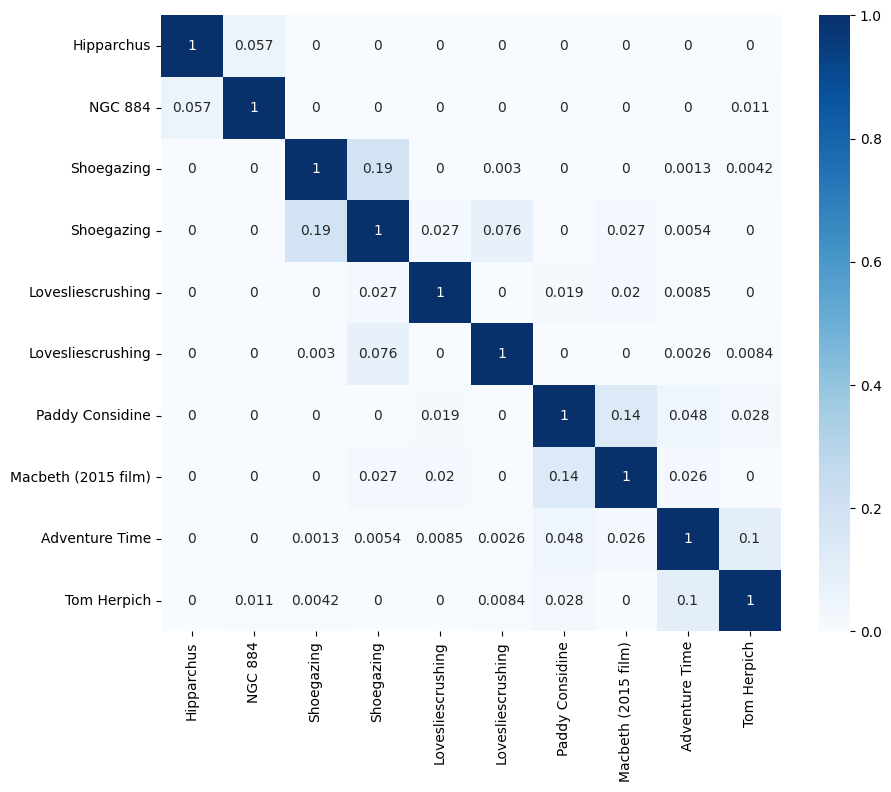

In [ ]:
# Plot the similarity matrix for the first 10 documents
plt.figure(figsize=(10, 8))
sns.heatmap(similarity, cmap='Blues', annot=True, xticklabels=labels[0:10], yticklabels=labels[0:10])
plt.show()

### Clustering


We use MiniBatchKMeans to iterate over different numbers of clusters and
record the corresponding inertia values. Based on this curve, we select a
reasonable number of clusters and then run standard KMeans with that value.


In [ ]:
from sklearn.cluster import MiniBatchKMeans

mini_inertia = []

for i in range (1,100):
  mb_kmeans = MiniBatchKMeans(n_clusters=i,batch_size=1500, random_state=2307)
  mb_kmeans.fit(vector_documents)
  mini_inertia.append(mb_kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


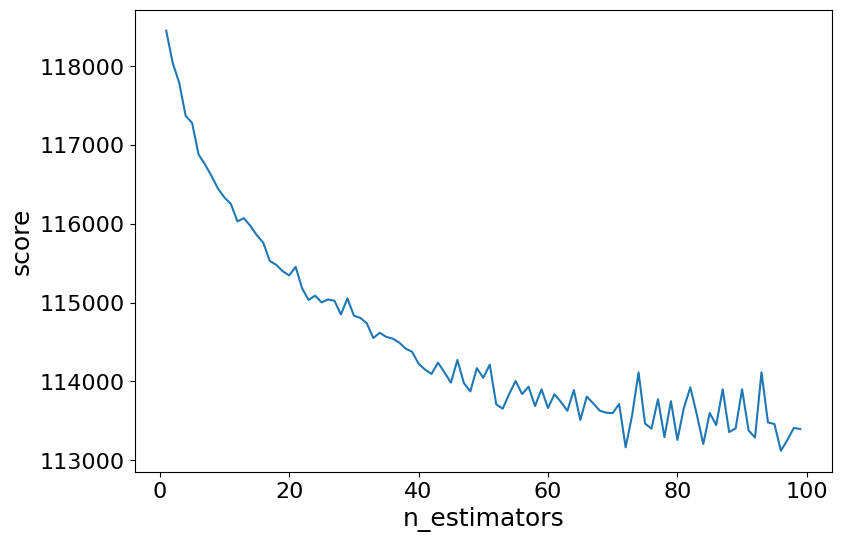

In [ ]:
my_mini_range = range(1, 100)

# Plot inertia as a function of the number of clusters
plt.figure(figsize=(9,6))
plt.plot(my_mini_range, mini_inertia)

# Adjust labels and font (to make it more readable)
plt.xlabel("n_estimators", fontsize = 18)
plt.ylabel("score", fontsize = 18)
plt.tick_params(labelsize = 16)

# Show the plot
plt.show()

There is no clear elbow in the inertia curve, but the values start to flatten
and become irregular after around 60 clusters. We therefore select 50 clusters
as a reasonable trade-off between compactness and complexity.


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50, max_iter=100, n_init=2, verbose=False, random_state=2307)
kmeans.fit(vector_documents)

KMeans(max_iter=100, n_clusters=50, n_init=2, random_state=2307, verbose=False)

By inspecting the most important vocabulary terms for the first few clusters
we can qualitatively assess whether the clusters are semantically coherent.


In [ ]:
for i in range (0,5):
  print('Cluster number : ' + str(i))
  centroid = kmeans.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  print([vocab[j] for j in sorted_terms[:20]])

Cluster number : 0
['used', 'known', 'time', 'new', 'group', 'world', 'based', 'people', 'years', 'including', 'called', 'year', 'use', '000', 'state', 'later', 'city', 'high', 'government', 'work']
Cluster number : 1
['director', 'film', 'screenwriter', 'producer', 'films', 'born', 'american', 'actor', 'writer', 'best', 'known', 'television', 'directed', 'directing', 'november', 'august', 'work', 'december', 'january', 'february']
Cluster number : 2
['league', 'season', 'baseball', 'hockey', 'team', 'cup', 'club', 'played', 'professional', 'major', 'football', 'nhl', 'national', 'mlb', 'player', 'ice', 'games', 'premier', 'won', 'teams']
Cluster number : 3
['music', 'musical', 'composer', 'country', 'american', 'songs', 'lyrics', 'known', 'artists', 'records', 'group', 'dance', 'rock', 'born', 'pop', 'singer', 'albums', 'classical', 'producer', 'record']
Cluster number : 4
['book', 'novel', 'published', 'books', 'author', 'comics', 'fiction', 'comic', 'writer', 'novels', 'american', '

We show the titles of twenty example documents belonging to the same cluster
to qualitatively evaluate cluster coherence.


In [ ]:
kmeans_labels = kmeans.labels_
for i in range (0,5):
  print('Cluster number : ' + str(i))
  centroid = kmeans.cluster_centers_[i]
  count = 0
  j = 0
  while (count < 20) :
    if (kmeans_labels[j] == i):
      print(labels[j] + ' |',  end=" ")
      count = count + 1
      j = j + 1
    j = j + 1

Cluster number : 0
Hipparchus | Shoegazing | Lovesliescrushing | Committee on Human Rights in the USSR | Memory | Religion in ancient Rome | Database | Hans Christian Andersen | Prashna Upanishad | Dodonaea | Kanye West | Meet Me in St. Louis | Lighting | Ethan Hardy | RLLMUK | Greater Talent Network | Jeremy Paxman | Department store | Mary, mother of Jesus | Wile E. Coyote and the Road Runner | Cluster number : 1
Lionel Friedberg | Michael Meredith | Armand Schaefer | Edward L. Cahn | Peter Chung | Shane Acker | Bill Kenwright | Sergio Leone | Gene Kranz | Ernst Lubitsch | Chris Harris (actor) | Rashida Jones | Léonce Perret | Jean Dréville | Satyajit Ray filmography | Min Kyu-dong | Manfred Noa | Arturo Ripstein | Joseph Ruben | John Huston | Cluster number : 2
David Hillier | 1929 Segunda División | 2017–18 Serie B | 2016–17 Serie B | Barry Larkin | 2001 Intercontinental Cup | Dayton Demonz | 2011 Minnesota Vikings season | Eddie Epstein | 2014 NBA Development League expansion draf

We project the high-dimensional TF–IDF vectors into 3 dimensions using
Truncated SVD and plot the resulting points in 3D, coloured according to
the cluster labels learned by KMeans.


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)

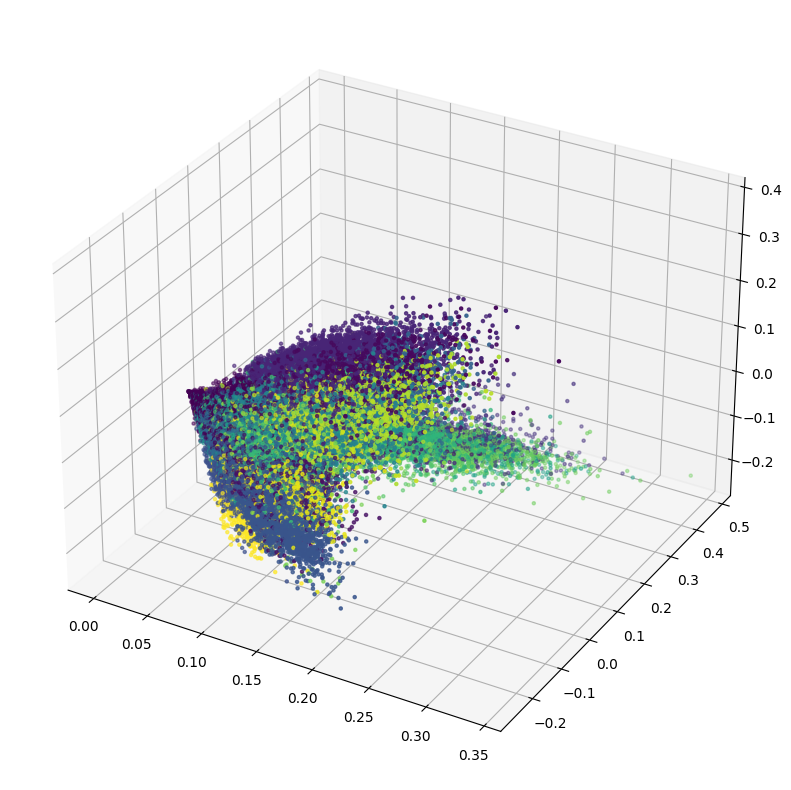

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.')